# Solving 1-D Schrodinger Equation with quadratic potential


In [1]:
# adapted from: https://github.com/c0rychu/SchrodingerEq_1D_tutorial/blob/master/SchrodingerEq_1D_tutorial.ipynb

In [2]:
from scipy import integrate
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rc('savefig', dpi=300)

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('default')
from matplotlib import rc, rcParams
# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to ‘Computer Modern’
rc('font',**{'size':16, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=5)
rc('xtick', labelsize=14)
rc('ytick.major', size=5, pad=5)
rc('ytick', labelsize=14)

## Set initial conditions

Normalization:
$$
\int d^dx |\psi|^2 = \frac{M}{m}= r_0^d \psi_0^2\int d^d \hat{x}|\hat{\psi}|^2
$$
so
$$
\int d^d \hat{x}|\hat{\psi}|^2 = \frac{M}{mr_0^d \psi_0^2} 
$$

1.0


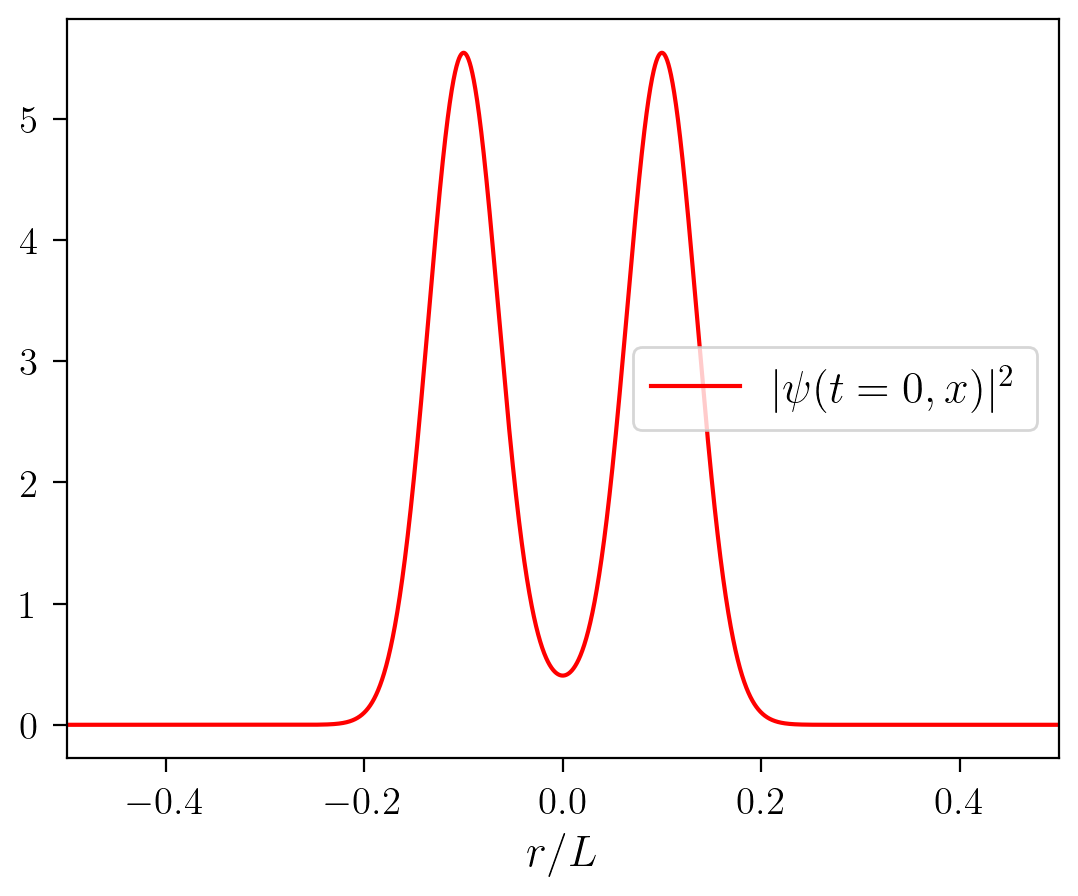

In [24]:
N    = 5000                     # spatial separation
L    = 40
x     = np.linspace(-L/2, L/2, N)       # spatial grid points
dx = L/N
m = 1
k0 = .25 #0.1                        # width of initial gaussian wave-packet
kx    = 1 #0.1                      # wave number
x0    = 1/k0                        # center of initial gaussian wave-packet
rho_avg = 1e0      # dimensionless
omega2 = 1 # dimensionless


# A = 1.0 / (k0 * np.sqrt(np.pi)) # normalization constant

# # Initial Wavefunction: psi0 =  normalization*(Random phase)*(Gaussian in x)*e^{i*k*x}
# psi0 = np.sqrt(0.5)*np.exp(1j*np.pi*float(np.random.rand(1)))* np.exp(-(x-x0)**2 * (2.0 * k0**2)) * np.exp(1j * kx * x)
# psi0 += np.sqrt(0.5)*np.exp(1j*np.pi*float(np.random.rand(1))) * np.exp(-(x+x0)**2 * (2.0 * k0**2)) * np.exp(1j * kx * x)


psi0 = np.exp(-(x-x0)**2 * (2.0 * k0**2)) * np.exp(1j * kx * x0)
psi0 +=  np.exp(-(x+x0)**2 * (2.0 * k0**2)) * np.exp(1j * kx * x0)


psi0 *= np.sqrt( rho_avg/ np.average(np.abs(psi0)**2)) # normalize

print(np.average(np.abs(psi0)**2))

# Potential V(x)
V = omega2*x**2

# Make a plot of psi0 and V 
#

plt.figure()
# plt.plot(x, V*1e-4, "k--", label=r"$V(r) \times 10^{-4}$")
plt.plot(x/L, np.abs(psi0)**2, "r", label=r"$\vert\psi(t=0,x)\vert^2$")
plt.xlabel(r"$r/L$")
plt.xlim([-20/L,20/L])
plt.legend()
# plt.yscale("log")
# plt.savefig('interference-1d-Schrodinger-IC.png', dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()
# print("Total Probability: ", np.sum(np.abs(psi0)**2))

## Laplace Operator (Finite Difference)

The 1-D Laplace operator $\nabla^2=\frac{\partial^2}{\partial x^2}$ can be expressed in terms of a banded matrix:

\begin{align}
\frac{\partial^2}{\partial x^2} y(x)
&= 
\frac{1}{dx} \left[ \frac{y_{n+1} - y_{n}}{dx} - \frac{y_{n} - y_{n-1}}{dx} \right]
\\
&=
\frac{y_{n+1} - 2 y_{n} + y_{n-1}}{(dx)^2} 
\\
&=
\frac{1}{(dx)^2}
\begin{pmatrix}
  -2  &  1  &  0  &  0 &  0 \\
   1  & -2  &  1  &  0 &  0 \\
   0  &  1  & -2  &  1 &  0 \\
   0  &  0  &  1  & -2 &  1 \\
   0  &  0  &  0  &  1 & -2 
\end{pmatrix}
\cdot
\begin{pmatrix}
   y_1   \\
   y_2   \\
   y_3   \\
   y_4   \\
   y_5  
\end{pmatrix}
\\
&\equiv
\mathbf{D2} \cdot \mathbf{y}
\end{align}

In [4]:
# Laplace Operator (Finite Difference)
D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / dx**2
D2.toarray()*dx**2

array([[-2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -2.]])

To test our $\mathbf{D2}$ operator, we can apply it on a $\sin(x)$ function to see if it gives us $\sin''(x)=-\sin(x)$

In [5]:
# plt.plot(x[1:-1], np.sin(x)[1:-1], label=r"$\sin(x)$")
# plt.plot(x[1:-1], D2.dot(np.sin(x))[1:-1], label=r"$\mathbf{D2} \cdot \sin(x) = -\sin(x)$")
# plt.legend(loc=1, fontsize=8, fancybox=False)

## Solve Schrodinger Equation

Original 1-D Schrodinger equation: $-\frac{\hbar^2}{2m}\nabla^2\psi + V \psi = i\hbar\frac{\partial}{\partial t}\psi$


=> $\text{psi_t} \equiv \frac{\partial}{\partial t}\psi(t,x) = -i\left[-\frac{\hbar}{2m}\nabla^2\psi(t,x) + \frac{1}{\hbar} V(x) \psi(t,x)\right]$

## CC:
We solve dimensionless SE:
$$
i \psi' = -\partial_r^2\psi+\omega^2r^2\psi+\epsilon|\psi|^2\psi
$$
where $( \ )'$ denotes time derivative, and we are working in units
$$
T_0=2mr_0^2, \quad \omega_0 = \frac{1}{mr_0^2},\quad  \epsilon=g m \psi_0^2 r_0^2
$$
where $\epsilon$ is a small number that parameterizes self-interactions. 

In [6]:
# RHS of Schrodinger Equation
hbar = 1
# hbar = 1.0545718176461565e-34
def psi_t(t, psi, eps):
    return -1j * (- 1 * hbar / m * D2.dot(psi) + V / hbar * psi + eps*np.abs(psi)**2*psi)

In [7]:
dt = dx #dx**2  # time interval for snapshots
t0 = 0.0    # initial time
tf = np.pi/np.sqrt(omega2)/4  # final time
t_eval = np.arange(t0, tf, dt)  # recorded time shots

# Solve the Initial Value Problem
sol = integrate.solve_ivp(psi_t, t_span = [t0, tf], y0 = psi0, t_eval = t_eval, method="RK23",args=(0,))
#sol0p1 = integrate.solve_ivp(psi_t, t_span = [t0, tf], y0 = psi0, t_eval = t_eval, method="RK23",args=(0.1,))

## Plotting

In [8]:
# fig = plt.figure(figsize=(6, 4))
# for i, t in enumerate(sol.t):
#     plt.plot(x, np.abs(sol.y[:,i])**2)             # Plot Wavefunctions
# #     print(np.sum(np.abs(sol.y[:,i])**2)*dx)        # Print Total Probability (Should = 1)
# plt.plot(x, V * 1e-4, "k--", label=r"$V(x)\times 10^{-4}$")   # Plot Potential
# plt.legend(loc=1, fontsize=8, fancybox=False)
# fig.savefig('sho@2x.png')

In [9]:
eps = .5
sol0 = sol
sol10 = integrate.solve_ivp(psi_t, t_span = [t0, tf], y0 = psi0, t_eval = t_eval, method="RK23",args=(eps,))

delta0 = np.abs(sol0.y[:,-1])**2/np.average(np.abs(sol0.y[:,-1])**2)-1
delta10 = np.abs(sol10.y[:,-1])**2/np.average(np.abs(sol10.y[:,-1])**2)-1

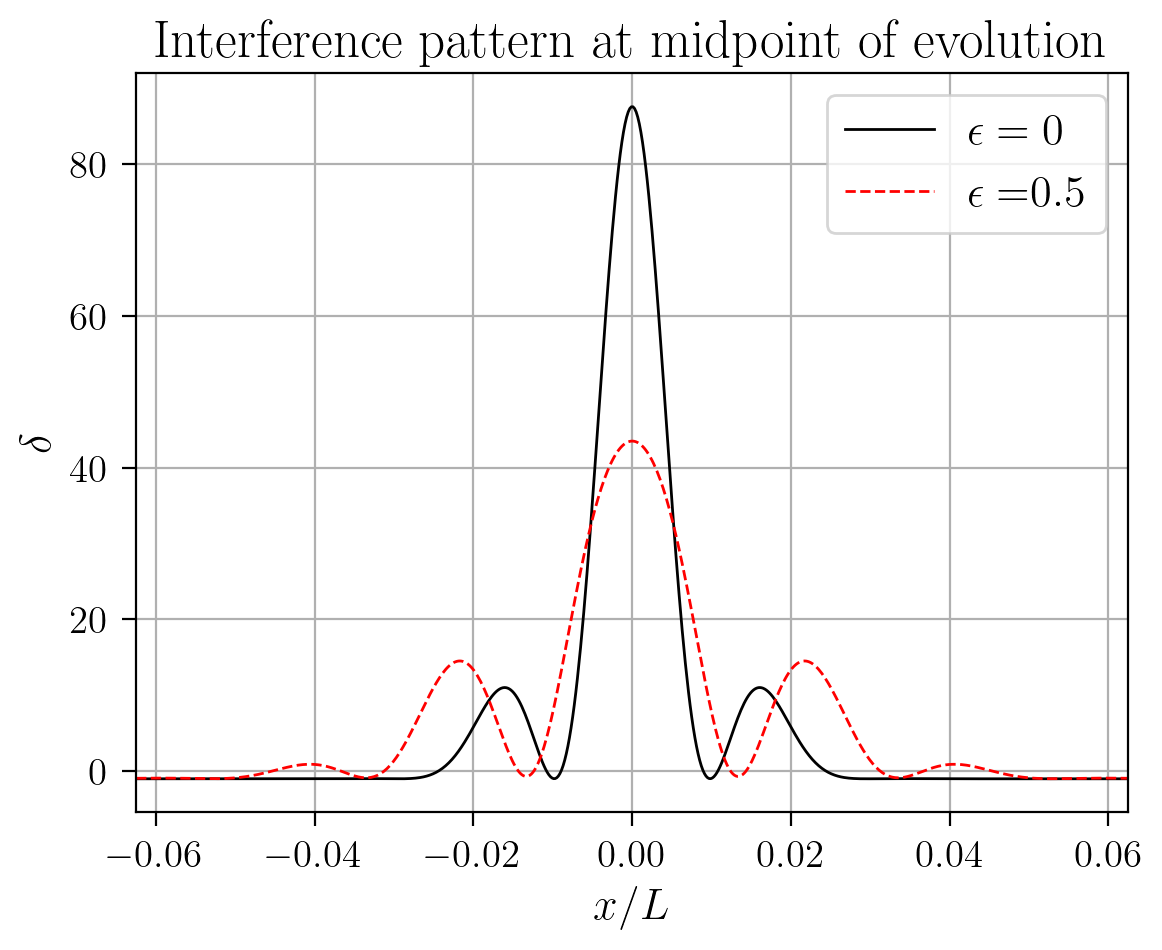

In [10]:
plt.figure()
plt.plot(x/L,delta0,'k',label=r'$\epsilon=0$',linewidth=1)
plt.plot(x/L,delta10,'r--',label=r'$\epsilon=$'+str(eps),linewidth=1)
plt.title('Interference pattern at midpoint of evolution')
plt.ylabel(r'$\delta$')
plt.xlabel(r'$x/L$')
plt.grid()
plt.legend()
plt.xlim(-2.5/L,2.5/L)
# plt.yscale("log")
plt.savefig('interference-1d-Schrodinger.png', dpi = 300, facecolor="white", bbox_inches = "tight")
#plt.plot(x,sol0.y[:,50])

# Automated pipeline to find scaling

In [11]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths

def test_func(position, amp, width, freq, shift):
    return (1+amp) *  (np.cos((position-shift)*freq))**2 *np.exp(-((position-shift)/ width)**2/2)-1

def fit(position, rho):
    popt, pcov = curve_fit(test_func, position, rho, bounds=(0,np.inf) )
    return popt, pcov

def pipeline(x, t0, tf, t_eval, couplings):
    
    densities = []
    seps = []
    widths = []
    params = np.zeros((len(couplings), 4))
    errors = np.zeros((len(couplings), 4))
    i = 0
    for eps in couplings:
        rho = np.abs(integrate.solve_ivp(psi_t, t_span = [t0, tf], 
                                                    y0 = psi0, t_eval = t_eval, 
                                                    method="RK23",
                                                    args=(eps,)).y[:,-1])**2
        delta = rho/np.average(rho)-1
        densities.append(rho)
        
        index_peaks, _ = find_peaks(delta, height = 5)
        i1 = index_peaks[0]
        i2 = index_peaks[1]
        sep = x[i2] - x[i1] #peak separation
        width = peak_widths(delta, index_peaks, rel_height=0.5)
        seps.append(sep)
        widths.append(np.max(width))
        
        p, c = fit(x, delta)
        params[i,:] = p
        errors[i,:] = np.sqrt(np.diag(c))
        i+=1
    return densities, seps, widths, params, errors

        
epsilons = [0, -0.1,-0.05, 0.05, 0.1]

rhos, seps, widths, params, errors = pipeline(x, t0, tf, t_eval, epsilons)

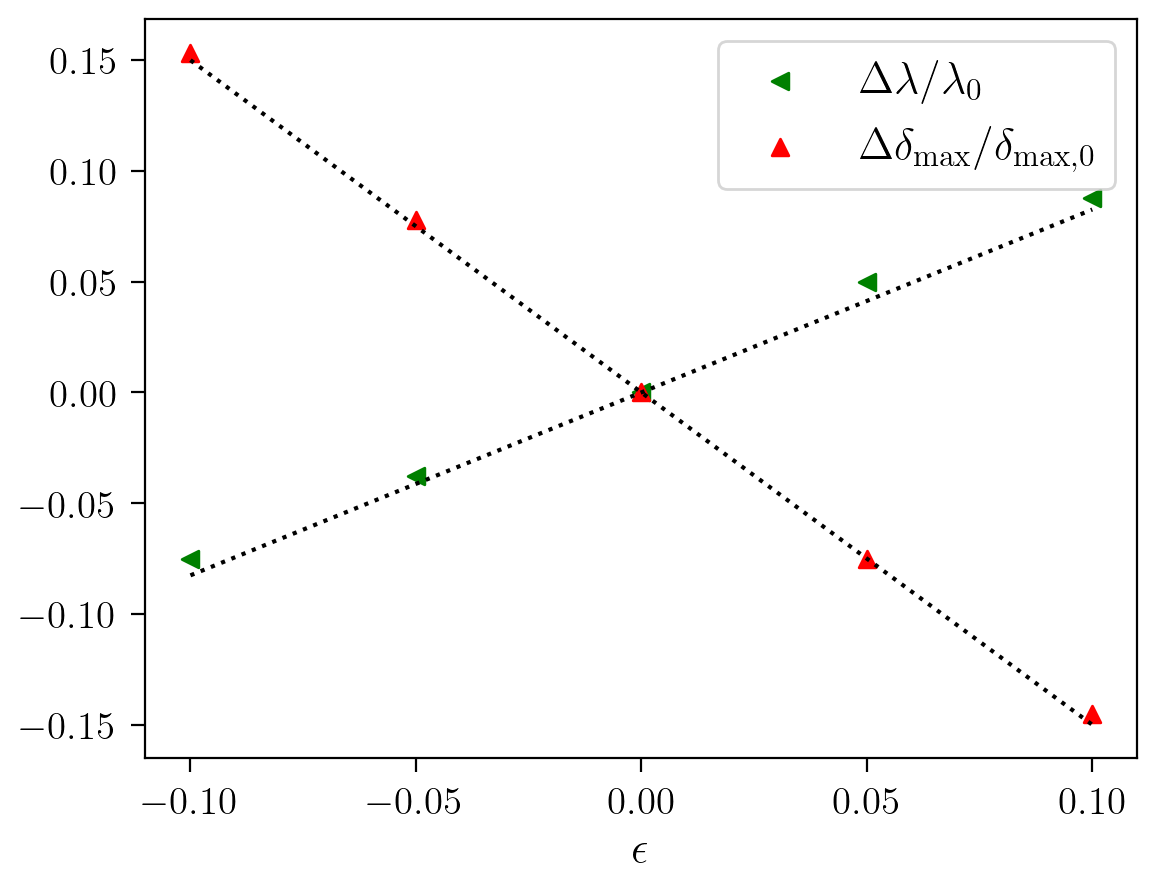

In [20]:
#function to linear-fit simulations against coupling
def fit_line(couplings, data):
    def line(couplings , slope):
        return 1+slope*couplings*rho_avg/np.sqrt(omega2)*np.pi/2

    param, cov = curve_fit(line, couplings, data)
    return param[0], np.sqrt(cov[0,0])


# delta_max, decay width, and wavenumber linear fits
slope_delta, error_delta = fit_line(epsilons, params[:,0]/params[0,0]-1)
slope_width, error_width = fit_line(epsilons, params[:,1]/params[0,1]-1)
slope_k, error_k = fit_line(epsilons, params[:,2]/params[0,2]-1)

# delta max numerical
rhos = np.asarray(rhos)
max_deltas = []
n=0
for g in epsilons:
    max_deltas.append( np.max(rhos[n,:])/np.average(rhos[n,:])-1 )
    n += 1
slope_delta_max, error_delta_max = fit_line(epsilons, max_deltas/max_deltas[0]-1)
slope_width_max, error_width_max = fit_line(epsilons, widths/widths[0]-1)
slope_peak_sep, error_peak_sep = fit_line(epsilons, seps/seps[0]-1)


# Plot deltas
# plt.figure()
# plt.ylabel(r"$\frac{\Delta\delta_{\mathrm{max}}}{\delta_{\mathrm{max},0}}$", rotation=0, labelpad=18)
# plt.xlabel(r"$\epsilon$")
# plt.plot(epsilons[1:], np.asarray(epsilons[1:])*slope_delta_max*rho_avg/np.sqrt(omega2)*np.pi/2,":k", label = str(round((slope_delta_max),2))+r" $\tilde{t}_{1/4}\langle |\tilde{\psi}|^2 \rangle \epsilon$",mfc='red', mec='r')
# # plt.plot(epsilons[1:], np.asarray(epsilons[1:])*slope_delta*rho_avg/np.sqrt(omega2)*np.pi/2,"k--", label = str(round((slope_delta),2))+r" $\epsilon\langle |\tilde{\psi}|^2 \rangle\tilde{t}_{1/4}$")
# plt.scatter(epsilons, max_deltas/max_deltas[0]-1, marker="^", color="r", label=r"Simulation")
# # plt.errorbar(epsilons, params[:,0]/params[0,0]-1, yerr=errors[:,0]/params[0,0], fmt="o", capsize=7, label="Fit Parameter")
# # plt.fill_between(epsilons[1:], np.asarray(epsilons[1:])*(slope_delta+error_delta)+1, np.asarray(epsilons[1:])*(slope_delta-error_delta)+1)
# plt.legend()
# # plt.xscale("symlog")
# # plt.savefig("fractional-delta-1d.png", dpi = 300, facecolor="white", bbox_inches = "tight")
# plt.show()

# Plot peak separation
plt.figure()
plt.plot(epsilons[1:], np.asarray(epsilons[1:])*slope_peak_sep*rho_avg/np.sqrt(omega2)*np.pi/2,":k")#, label = str(round((slope_peak_sep),2))+r" $\tilde{t}_{1/4}\langle |\tilde{\psi}|^2 \rangle \epsilon$",mfc='red', mec='r')
plt.scatter(epsilons[:], np.asarray(seps[:])/seps[0]-1, marker="<", color="g",label=r"$\Delta\lambda/\lambda_0$")
plt.plot(epsilons[1:], np.asarray(epsilons[1:])*slope_delta_max*rho_avg/np.sqrt(omega2)*np.pi/2,":k")#, label = str(round((slope_delta_max),2))+r" $\tilde{t}_{1/4}\langle |\tilde{\psi}|^2 \rangle \epsilon$",mfc='red', mec='r')
# plt.plot(epsilons[1:], np.asarray(epsilons[1:])*slope_delta*rho_avg/np.sqrt(omega2)*np.pi/2,"k--", label = str(round((slope_delta),2))+r" $\epsilon\langle |\tilde{\psi}|^2 \rangle\tilde{t}_{1/4}$")
plt.scatter(epsilons, max_deltas/max_deltas[0]-1, marker="^", color="r", label=r"$\Delta\delta_{\mathrm{max}}/\delta_{\mathrm{max},0}$")
plt.legend()
# plt.ylabel(r"$\frac{\Delta\lambda}{\lambda_0}$", rotation=0, labelpad=15, fontsize=14)
plt.xlabel(r"$\epsilon$")
plt.savefig("fractional-sho-1d.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

# plot dimensionless power spectrum k*P(k)

In [13]:
# N = 2000

# print()

test=np.fft.fftshift(np.fft.fft(np.abs(psi0)**2,N))

xf = np.linspace(-1.0/(2.0*dx), 1.0/(2.0*dx), N) # k 
# xf = np.linspace(1/N, 1.0/(2.0*dx), N) # k 
FFT0=np.fft.fftshift(np.fft.fft(np.abs(sol0.y[:,-1])**2,N)) # P(k)
FFT10=np.fft.fftshift(np.fft.fft(np.abs(sol10.y[:,-1])**2,N)) #P(k)
freq = np.fft.fftfreq(N)/dx

print(freq.shape)

(5000,)


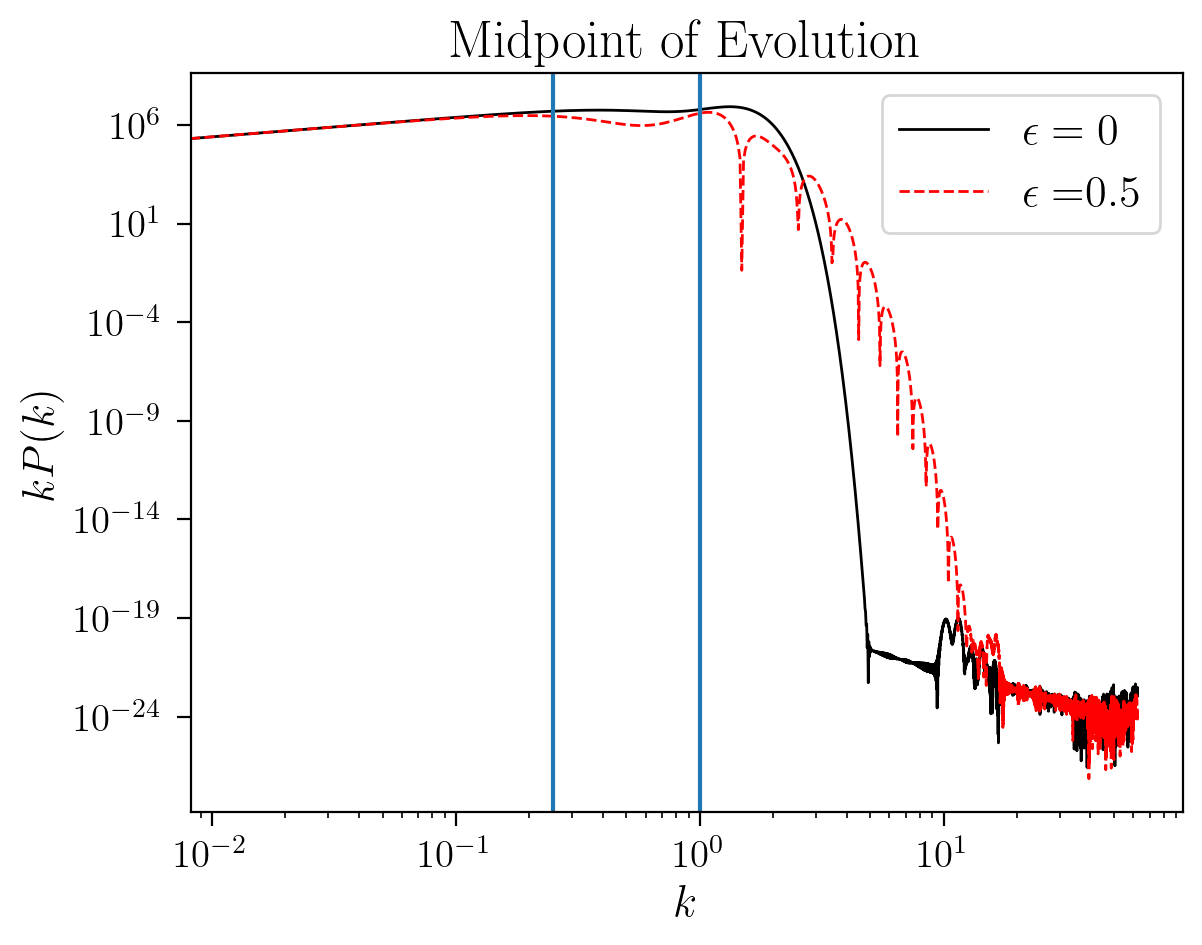

In [14]:
plt.figure()
plt.plot(xf,xf*np.abs(FFT0)**2,'k',label=r'$\epsilon=0$',linewidth=1)
plt.plot(xf,xf*np.abs(FFT10)**2,'r--',label=r'$\epsilon=$'+str(eps),linewidth=1)
# plt.plot(xf,xf*np.abs(test)**2,'g:',label='intial',linewidth=1)

# plt.plot(freq,freq*np.abs(FFT0)**2,'k',label=r'$\epsilon=0$',linewidth=1)
# plt.plot(freq,freq*np.abs(FFT10)**2,'r--',label=r'$\epsilon=$'+str(eps),linewidth=1)
# plt.plot(freq,freq*np.abs(test)**2,'g:',label='intial',linewidth=1)

#plt.yscale('log')
#plt.ylim([1e-5,1e3])
plt.axvline(x=k0)
plt.axvline(x=kx)
plt.ylabel(r'$kP(k)$')
plt.xlabel(r'$k$')
plt.legend()
# plt.xlim([0,1])
plt.yscale("log")
plt.xscale("log")
# plt.ylim([1e-3,10*np.max(xf*np.abs(FFT0)**2)])
plt.title('Midpoint of Evolution')
# plt.savefig('interference-power-spectrum-midpoint.pdf')
plt.show()

